This EQP1A model was developed using Gus Anthon's [pywdf library](https://github.com/gusanthon/pywdf) for Python. In this notebook you can find the Python implementation of the circuit using Wave Digital Filters (WDF) and a test of the developed model measuring its frequency response and processing some test signals.

In [10]:
# I'm working on Google Drive so I mount my Drive into Colab and change the working directory to the project folder.
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/Master Thesis/Notebooks/Python_prototype'
# os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!apt install portaudio19-dev
%pip install pyaudio
%pip install -U setuptools==58.0.4
%pip install git+https://github.com/gusanthon/pywdf

"apt" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/gusanthon/pywdf to c:\users\alber\appdata\local\temp\pip-req-build-nt0_iway
  Resolved https://github.com/gusanthon/pywdf to commit 669299e701558254a256504bbb0533eca59b58e3
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/gusanthon/pywdf 'C:\Users\alber\AppData\Local\Temp\pip-req-build-nt0_iway'


In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import matplotlib.ticker as ticker
from tqdm import trange
import time

from EQP1A import PultecEQP1A

In [5]:
eqp1a = PultecEQP1A(
    fs = 96_000, LoBoost = 0.00001, LoCut = 0.00001,
    HiBoost = 0.00001, HiCut = 0.00001, HiBQ = 0.5,
    LoFreq = 100, HiBoostFreq = 8e3, HiCutFreq = 10e3
)

In [12]:
def measure_performance(self, t, n):
    # Performance measurement
    times = []
    self.reset()
    inSamples = np.random.rand(t * self.fs)

    for i in trange(n):
      startTime = time.monotonic()
      for sample in inSamples:
        self.process_sample(sample)
      endTime = time.monotonic()
      times.append(endTime - startTime)
    
    if t != 1:
      s = 's'
    else:
      s = ''
    time_to_process = np.mean(times)
    print(f'\nAverage time to process {t} second{s} of audio @ {eqp1a.fs / 1000:.0f} kHz: {time_to_process:.3f} s\n')

    return time_to_process

In [24]:
eqp1a = PultecEQP1A(
    fs = 96_000, LoBoost = 0.00001, LoCut = 0.00001,
    HiBoost = 0.00001, HiCut = 0.00001, HiBQ = 0.5,
    LoFreq = 100, HiBoostFreq = 8e3, HiCutFreq = 10e3
)
time_to_process = {}
for fs in [48_000, 96_000, 192_000]:
    print('Measuring performance for fs =', int(fs/1000), 'kHz ...')
    t = 20
    n = 5
    eqp1a.set_sample_rate(fs)
    time_to_process[fs] = measure_performance(eqp1a, t, n)

Measuring performance for fs = 48 kHz ...


100%|██████████| 5/5 [02:14<00:00, 26.97s/it]



Average time to process 20 seconds of audio @ 48 kHz: 26.969 s

Measuring performance for fs = 96 kHz ...


100%|██████████| 5/5 [04:29<00:00, 53.93s/it]



Average time to process 20 seconds of audio @ 96 kHz: 53.931 s

Measuring performance for fs = 192 kHz ...


100%|██████████| 5/5 [09:04<00:00, 108.98s/it]


Average time to process 20 seconds of audio @ 192 kHz: 108.984 s



In [4]:
def compare_with_LTSpice_response(self, file_path, title):
    # Initialize empty arrays
    frequencies = []
    LTSpice_magnitude = []

    # Read the file
    with open(file_path, 'r', encoding='latin-1') as file:
        # Skip the header line
        next(file)

        # Read each line
        for line in file:
            # Split the line by tab and whitespace
            values = line.strip().split('\t')

            # Extract frequency and magnitude values
            frequency = float(values[0])
            magnitude = float(values[1].split('(')[1].split('dB')[0])

            # Append values to arrays
            frequencies.append(frequency)
            LTSpice_magnitude.append(magnitude)

    # Convert lists to NumPy arrays
    frequencies = np.array(frequencies)
    LTSpice_magnitude = np.array(LTSpice_magnitude)

    H = self.compute_spectrum(fft_size=int((len(LTSpice_magnitude) + 2) * 2 + 1))[1:]
    nyquist = self.fs / 2
    pywdf_magnitude = 20 * np.log10(np.abs(H) + np.finfo(float).eps)

    linear_pywdf_mag = np.abs(H)
    del(H)
    linear_LTSpice_mag = 10 ** (LTSpice_magnitude / 20)
    error = (linear_LTSpice_mag - linear_pywdf_mag)**2

    fig = plt.figure(figsize=(10, 4))

    ax = fig.add_subplot(111)

    ax.semilogx(frequencies, LTSpice_magnitude, color = 'C0', label=r"$|H_{LTSpice}(f)|$[dB]")
    ax.semilogx(frequencies, pywdf_magnitude, color = 'C1', label=r"$|H_{pywdf}(f)|$[dB]")
    ax.legend()
    ax.set_title(f"Magnitude response: {title} @ {self.fs / 1000:.0f} kHz")
    ax.grid(True, which='both')
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Magnitude [dB]")
    ax.set_xlim(20, 20_000)
    ymin = np.floor(min(LTSpice_magnitude)/2)*2
    ymax = np.ceil(max(LTSpice_magnitude)/2)*2
    ax.set_yticks(np.arange(ymin, ymax + 2, 2))
    ax.set_ylim(ymin, ymax)

    # Set the x-axis tick formatter
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:0g}'.format(x)))
    ax.set_xticks([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000])

    error_matrix = np.tile(error, (3, 1))

    X = frequencies
    Y = np.linspace(-20, 20, num=3)

    norm = matplotlib.colors.LogNorm(vmin=1e-8, vmax=1e-3)
    pcm = ax.pcolormesh(X, Y, error_matrix, cmap = 'binary', norm = norm)

    # Create colorbar
    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label(r"Squared error")

    # Add text annotation for error
    # error_rms_20_24 = np.sqrt(np.mean(error[:4096]))
    error_rms = np.sqrt(np.mean(error))
    latex_error_rms = r"${Error_{RMS}}$" + f' = {error_rms:.2e}'
    ax.text(0.05, 0.1, latex_error_rms, bbox=dict(boxstyle='round', fc='w', ec='gray', alpha=0.7), transform=ax.transAxes)

    ### FIX AXIS: Step 2 and limits multiples of 2

    plt.tight_layout()
    plt.show()

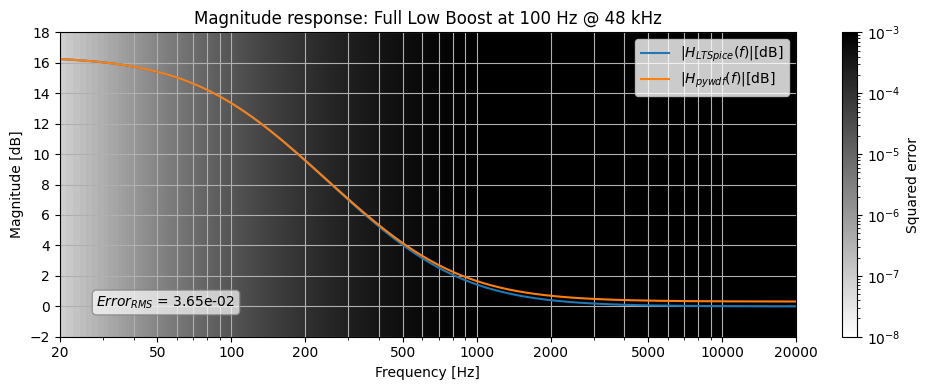

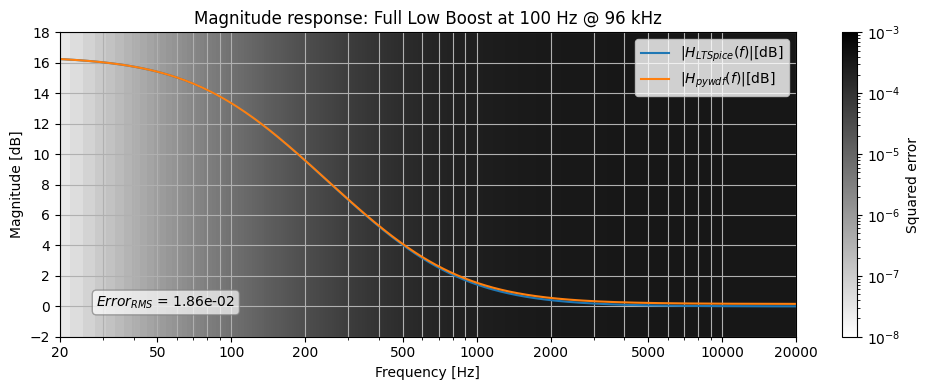

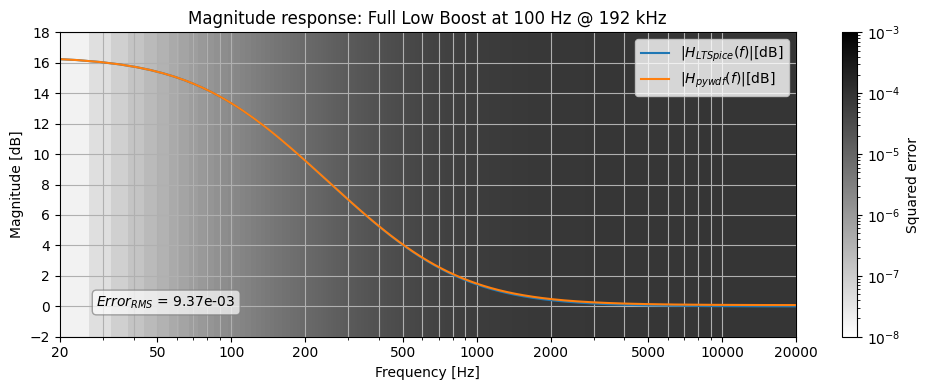

In [5]:
eqp1a = PultecEQP1A(
    fs = 48_000, LoBoost = 0.99999, LoCut = 0.00001,
    HiBoost = 0.00001, HiCut = 0.00001, HiBQ = 0.5,
    LoFreq = 100, HiBoostFreq = 8e3, HiCutFreq = 10e3
)

for fs in [48, 96, 192]:
    eqp1a.set_sample_rate(fs * 1000)
    compare_with_LTSpice_response(eqp1a,  f'LTSpice_responses\{fs}kHz\LoBoost_100Hz_{fs}kHz.txt', "Full Low Boost at 100 Hz")

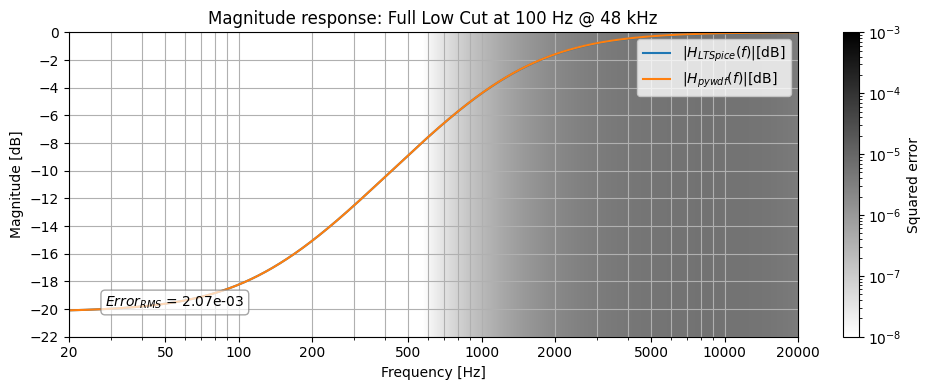

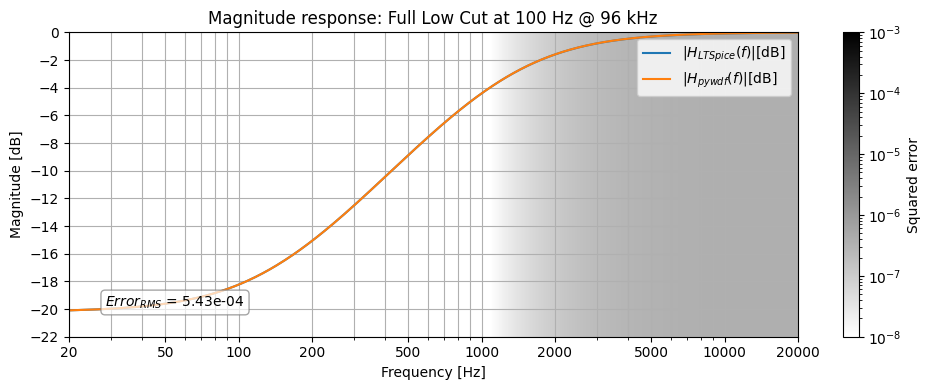

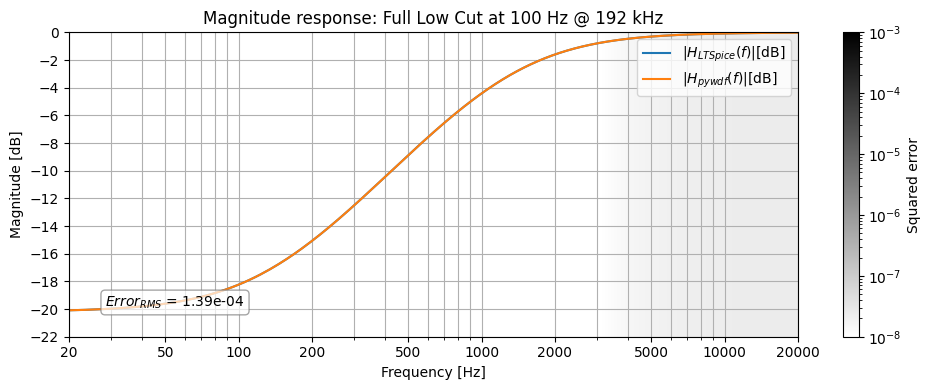

In [6]:
eqp1a = PultecEQP1A(
    fs = 192_000, LoBoost = 0.00001, LoCut = 0.99999,
    HiBoost = 0.00001, HiCut = 0.00001, HiBQ = 0.5,
    LoFreq = 100, HiBoostFreq = 8e3, HiCutFreq = 10e3
)
for fs in [48, 96, 192]:
    eqp1a.set_sample_rate(fs * 1000)
    compare_with_LTSpice_response(eqp1a,  f'LTSpice_responses\{fs}kHz\LoCut_100Hz_{fs}kHz.txt', f'Full Low Cut at 100 Hz')

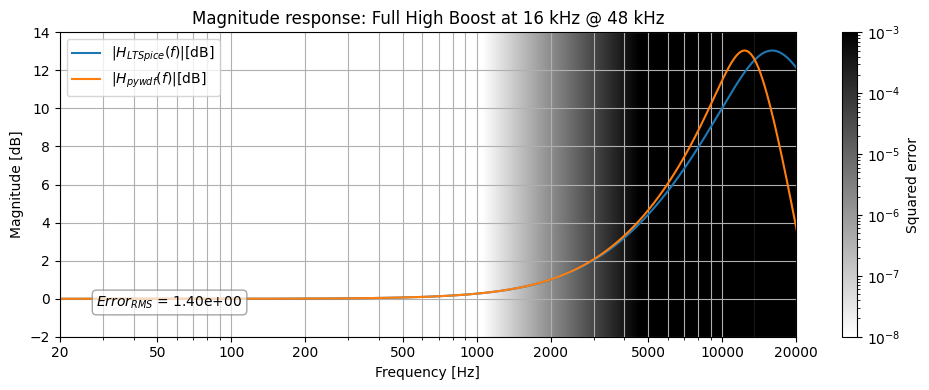

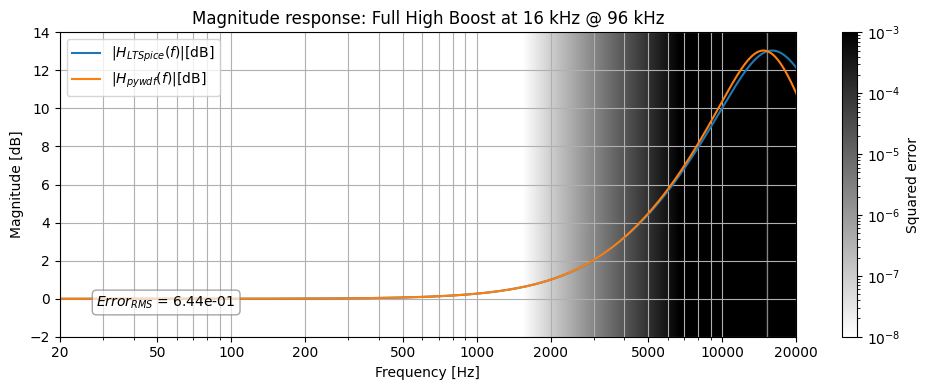

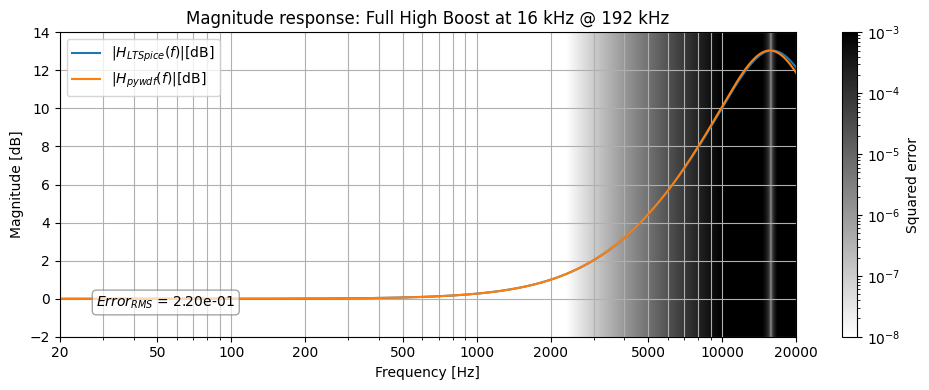

In [7]:
eqp1a = PultecEQP1A(
    fs = 192_000, LoBoost = 0.00001, LoCut = 0.00001,
    HiBoost = 0.99999, HiCut = 0.00001, HiBQ = 0.5,
    LoFreq = 100, HiBoostFreq = 16e3, HiCutFreq = 10e3
)
for fs in [48, 96, 192]:
    eqp1a.set_sample_rate(fs * 1000)
    compare_with_LTSpice_response(eqp1a,  f'LTSpice_responses\{fs}kHz\HiBoost_16kHz_{fs}kHz.txt', f'Full High Boost at 16 kHz')

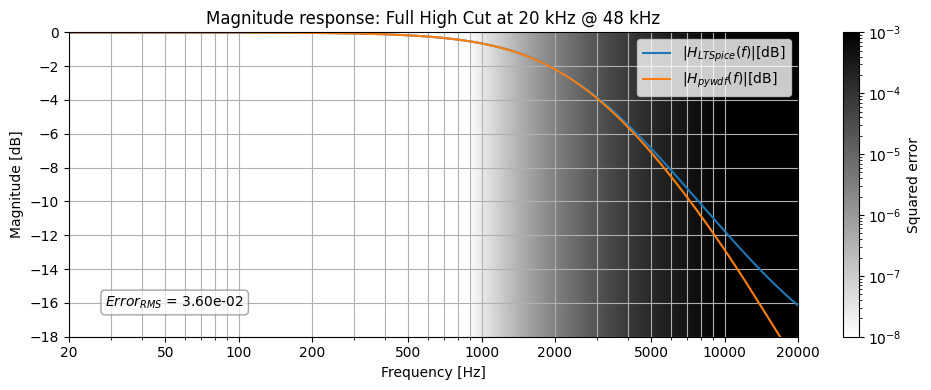

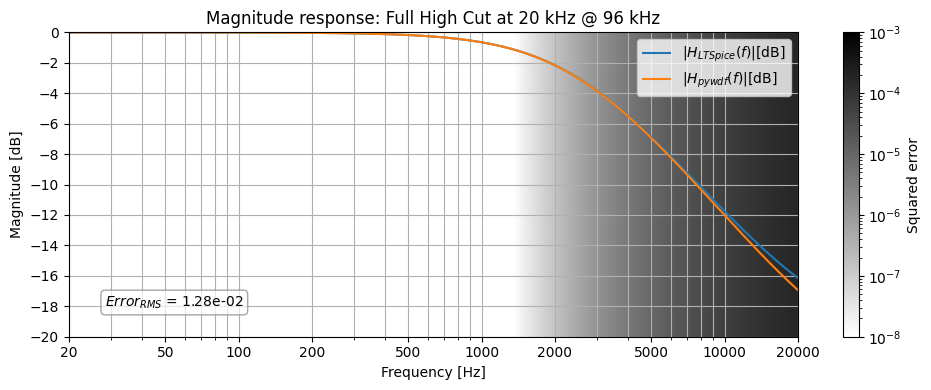

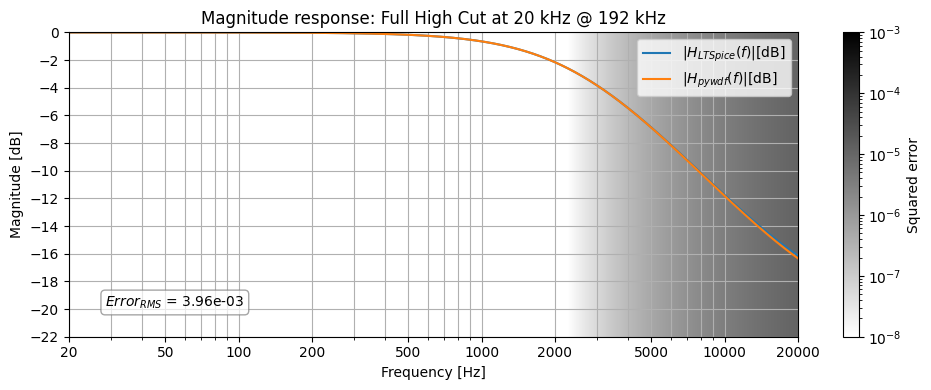

In [8]:
eqp1a = PultecEQP1A(
    fs = 192_000, LoBoost = 0.00001, LoCut = 0.00001,
    HiBoost = 0.00001, HiCut = 0.99999, HiBQ = 0.5,
    LoFreq = 100, HiBoostFreq = 8e3, HiCutFreq = 20e3
)

for fs in [48, 96, 192]:
    eqp1a.set_sample_rate(fs * 1000)
    compare_with_LTSpice_response(eqp1a,  f'LTSpice_responses\{fs}kHz\HiCut_20kHz_{fs}kHz.txt', 'Full High Cut at 20 kHz')

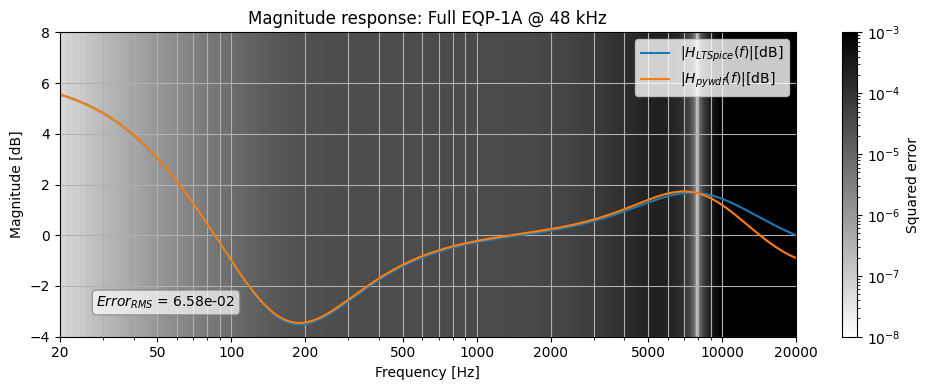

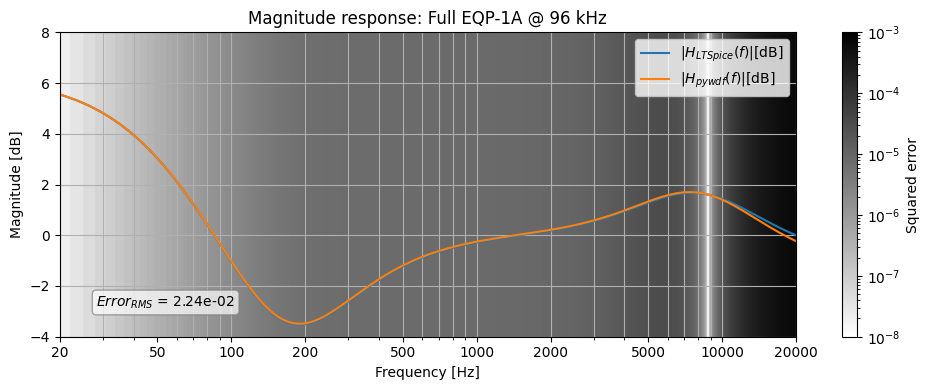

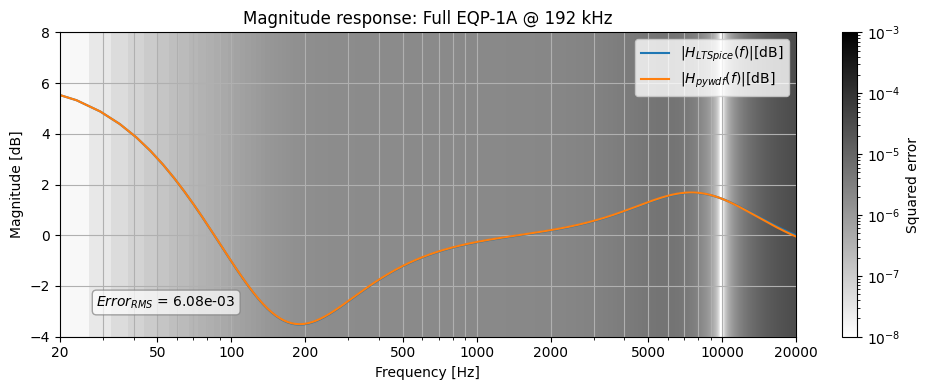

In [9]:
eqp1a = PultecEQP1A(
    fs = 192_000, LoBoost = 0.2, LoCut = 0.2,
    HiBoost = 0.4, HiCut = 0.2, HiBQ = 0.5,
    LoFreq = 20, HiBoostFreq = 8e3, HiCutFreq = 10e3
)
for fs in [48, 96, 192]:
    eqp1a.set_sample_rate(fs * 1000)
    compare_with_LTSpice_response(eqp1a,  f'LTSpice_responses\{fs}kHz\EQP1A_ExampleResponse_{fs}kHz.txt', "Full EQP-1A")